$TSLA | 07/11 - 07/19 | topic for 15 + Clean more data(advertisement) + topic again for 8 + Kmeans Clustering Topic + add more filter & stopwords

# Load raw tweets   + Drop text duplicate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS  
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans

import datetime as dt
import pandas_datareader.data as web

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
df = pd.read_csv("../data/scraped_tweets.csv")
df.drop("Unnamed: 0", axis =1, inplace = True) 
df.head()

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
0,2021-07-19 21:17:28,Smith28301,Best discord for the traders with more execut...,NaN,0.0,78,1495,0.0,Bullish earnings. We were on the right side of...,[]
1,2021-07-19 21:17:21,EvrybodynthrMom,"Embarrassing mom of a teenage tesla nerd, and ...",Belgium,3884.0,1269,31796,14.0,When $F reported YTD June 2021 U.S. sales up 5...,[]
2,2021-07-19 21:16:59,mike23432813,My investment style has altered to more of a m...,NaN,65.0,138,1400,3.0,$MRNA really is the new $TSLA,[]
3,2021-07-19 21:16:53,TDogetronaut,ICE age is over! 🌏 🌎 🌍 🚀 🚀 🚀 MarsCoin & TriMot...,United States,147.0,211,14980,32.0,$TSLA in the green despite the Dow being down ...,[]
4,2021-07-19 21:16:20,DominicRinaldi9,Founder of Dom's Deep Dives an affiliate of th...,"Nashville, TN",1016.0,1921,2087,0.0,"10. Read their S-1, Investor Presentations\n11...",[]


In [3]:
df.shape

(18019, 10)

In [4]:
# dropping ALL duplicate values but keep the first occur

df.drop_duplicates(subset ="text", inplace = True)  # keep = False,
df.reset_index(drop = True, inplace= True)
df.tail()

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
10091,2021-07-12 19:39:45,WPipperger,"Legacy lemming, tweeting about cars, economics...","Prag, Tschechische Republik",1357.0,2029.0,44149.0,0.0,"""“I think you are a bad human being,” Musk tol...",[]
10092,2021-07-12 19:39:22,OTBSharkMoh,Options Trader/Investor\nTrading Psychology Ge...,"Vancouver, British Columbia",167.0,1273.0,3122.0,0.0,"Great call-out, wasn't able to get in. I was e...",[]
10093,2021-07-12 19:39:07,Z54156997,A good macro trader | we are united by our amb...,"Cupertino, CA",583.0,898.0,6607.0,2.0,"$TSLA $700 call volume and price today. Tail, ...",[]
10094,2021-07-12 19:39:01,CBLoptsFeed,real time alerts for selected stocks options o...,NaN,0.0,102.0,12995.0,0.0,"15:36 -&gt; OATM Put, TSLA 210716P680, | at ...",[]
10095,2021-07-12 19:39:01,IdeasPrime,Follow me for real-time charts and technical a...,"London, England",0.0,6083.0,157550.0,0.0,"Tesla | $TSLA\n\nTSLA ""W"" pattern on weekly ch...",[]


In [5]:
df.shape    # 18019 cut down to 10096

(10096, 10)

##### check data timeframe

In [6]:
df.date.sort_values()

6908    2021-07-11 13:25:42
6907    2021-07-11 13:25:44
6906    2021-07-11 13:25:47
6905    2021-07-11 13:25:49
6904    2021-07-11 13:25:51
               ...         
3       2021-07-19 21:16:53
2       2021-07-19 21:16:59
1       2021-07-19 21:17:21
0       2021-07-19 21:17:28
1391                    NaN
Name: date, Length: 10096, dtype: object

##### what hashtag came up the most?


In [7]:
df.hashtags.value_counts()

[]                                                                                                                                                                                      7702
['Tesla']                                                                                                                                                                                144
['fintwit', 'investing', 'stocks', 'wallstreetbets']                                                                                                                                     100
['Options', 'OptionsTrading', 'OptionsFlow', 'optionstrade', 'optiontrading', 'stock', 'stocks', 'StockMarket', 'Investment', 'investing', 'invest', 'investor', 'investors', 'UOA']      97
['tesla']                                                                                                                                                                                 86
                                                       

### retweet times and content

In [8]:
df.retweetcount.value_counts(normalize=True)

# retweet times , retweet times count %

0.0       0.620802
1.0       0.173947
2.0       0.049827
3.0       0.026746
4.0       0.018722
            ...   
88.0      0.000099
65.0      0.000099
123.0     0.000099
1747.0    0.000099
266.0     0.000099
Name: retweetcount, Length: 151, dtype: float64

##### what tweet got the most retweet times?

In [9]:
df[df.retweetcount  == 1747.0]

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags
5422,2021-07-16 18:52:09,AnkitPa40149680,NaN,NaN,126.0,16,3320,1747.0,“I think it's basically financially insane to ...,[]


# Text Preprocessing
## remove  digits, punctations, url

In [10]:
# preprocessing  

def remove_pattern(df):
    """This function removes the user handle, URL, emojicons"""
    
    df['tidy_tweet'] = df['text'].str.replace(r'@[\w]*', '')
    df['tidy_tweet'] = df['tidy_tweet'].str.replace(r'https?:\/\/.*[\r\n]*', '')    # remove URL
    df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")  # remove digits
   # df['tidy_tweet'] = " ".join(df['tidy_tweet'].str.split())  # using split() + join()  # remove additional space from string 
    
    
    return df

In [12]:
remove_pattern(df)

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,tidy_tweet
0,2021-07-19 21:17:28,Smith28301,Best discord for the traders with more execut...,NaN,0.0,78,1495,0.0,Bullish earnings. We were on the right side of...,[],Bullish earnings We were on the right side of...
1,2021-07-19 21:17:21,EvrybodynthrMom,"Embarrassing mom of a teenage tesla nerd, and ...",Belgium,3884.0,1269,31796,14.0,When $F reported YTD June 2021 U.S. sales up 5...,[],When F reported YTD June U S sales up ...
2,2021-07-19 21:16:59,mike23432813,My investment style has altered to more of a m...,NaN,65.0,138,1400,3.0,$MRNA really is the new $TSLA,[],MRNA really is the new TSLA
3,2021-07-19 21:16:53,TDogetronaut,ICE age is over! 🌏 🌎 🌍 🚀 🚀 🚀 MarsCoin & TriMot...,United States,147.0,211,14980,32.0,$TSLA in the green despite the Dow being down ...,[],TSLA in the green despite the Dow being down ...
4,2021-07-19 21:16:20,DominicRinaldi9,Founder of Dom's Deep Dives an affiliate of th...,"Nashville, TN",1016.0,1921,2087,0.0,"10. Read their S-1, Investor Presentations\n11...",[],Read their S Investor Presentations ...
...,...,...,...,...,...,...,...,...,...,...,...
10091,2021-07-12 19:39:45,WPipperger,"Legacy lemming, tweeting about cars, economics...","Prag, Tschechische Republik",1357.0,2029.0,44149.0,0.0,"""“I think you are a bad human being,” Musk tol...",[],I think you are a bad human being Musk tol...
10092,2021-07-12 19:39:22,OTBSharkMoh,Options Trader/Investor\nTrading Psychology Ge...,"Vancouver, British Columbia",167.0,1273.0,3122.0,0.0,"Great call-out, wasn't able to get in. I was e...",[],Great call out wasn t able to get in I was e...
10093,2021-07-12 19:39:07,Z54156997,A good macro trader | we are united by our amb...,"Cupertino, CA",583.0,898.0,6607.0,2.0,"$TSLA $700 call volume and price today. Tail, ...",[],TSLA call volume and price today Tail ...
10094,2021-07-12 19:39:01,CBLoptsFeed,real time alerts for selected stocks options o...,NaN,0.0,102.0,12995.0,0.0,"15:36 -&gt; OATM Put, TSLA 210716P680, | at ...",[],gt OATM Put TSLA P at ...


In [13]:
df['text'][0]

'Bullish earnings. We were on the right side of this one for some nice gains."\n\n$SSPK $SUNW $SVVC $SZK $THBR $TWM $TZA $USDU $SUNW $AAPL $SQQQ $POLA $TSLA $NKLA $NETE $AMD $AAL $OGE $QQQ $TQQQ $CBAT $WKHS $SPI $PLUG $NAKD $SOLO $SPXU https://t.co/EodHcEvk74'

In [14]:
df['tidy_tweet'][0]

'Bullish earnings  We were on the right side of this one for some nice gains     SSPK  SUNW  SVVC  SZK  THBR  TWM  TZA  USDU  SUNW  AAPL  SQQQ  POLA  TSLA  NKLA  NETE  AMD  AAL  OGE  QQQ  TQQQ  CBAT  WKHS  SPI  PLUG  NAKD  SOLO  SPXU '

In [356]:
# if didnt do 3 stem and tokenize -> can use this -> using split() + join() # remove additional space from string 

res = " ".join(df['tidy_tweet'][0].split())
res

#  df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

'Bullish earnings We were on the right side of this one for some nice gains SSPK SUNW SVVC SZK THBR TWM TZA USDU SUNW AAPL SQQQ POLA TSLA NKLA NETE AMD AAL OGE QQQ TQQQ CBAT WKHS SPI PLUG NAKD SOLO SPXU'

## stem and tokenize
TA: can try with/without stem 

In [15]:
from nltk.stem.porter import *

def tokenize_and_stem(df):
    """This function tokenizes the tweets and stems them and then
    joins them back together."""
    tokenized_tweet = df['tidy_tweet'].astype(str).str.split()  # apply(lambda x: x.split()) #.lower().split(' ')
    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    df['tidy_tweet'] = tokenized_tweet
    return df

In [16]:
tokenize_and_stem(df)

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,tidy_tweet
0,2021-07-19 21:17:28,Smith28301,Best discord for the traders with more execut...,NaN,0.0,78,1495,0.0,Bullish earnings. We were on the right side of...,[],bullish earn We were on the right side of thi ...
1,2021-07-19 21:17:21,EvrybodynthrMom,"Embarrassing mom of a teenage tesla nerd, and ...",Belgium,3884.0,1269,31796,14.0,When $F reported YTD June 2021 U.S. sales up 5...,[],when F report ytd june U S sale up year over y...
2,2021-07-19 21:16:59,mike23432813,My investment style has altered to more of a m...,NaN,65.0,138,1400,3.0,$MRNA really is the new $TSLA,[],mrna realli is the new tsla
3,2021-07-19 21:16:53,TDogetronaut,ICE age is over! 🌏 🌎 🌍 🚀 🚀 🚀 MarsCoin & TriMot...,United States,147.0,211,14980,32.0,$TSLA in the green despite the Dow being down ...,[],tsla in the green despit the dow be down point...
4,2021-07-19 21:16:20,DominicRinaldi9,Founder of Dom's Deep Dives an affiliate of th...,"Nashville, TN",1016.0,1921,2087,0.0,"10. Read their S-1, Investor Presentations\n11...",[],read their S investor present understand their...
...,...,...,...,...,...,...,...,...,...,...,...
10091,2021-07-12 19:39:45,WPipperger,"Legacy lemming, tweeting about cars, economics...","Prag, Tschechische Republik",1357.0,2029.0,44149.0,0.0,"""“I think you are a bad human being,” Musk tol...",[],I think you are a bad human be musk told randa...
10092,2021-07-12 19:39:22,OTBSharkMoh,Options Trader/Investor\nTrading Psychology Ge...,"Vancouver, British Columbia",167.0,1273.0,3122.0,0.0,"Great call-out, wasn't able to get in. I was e...",[],great call out wasn t abl to get in I wa entan...
10093,2021-07-12 19:39:07,Z54156997,A good macro trader | we are united by our amb...,"Cupertino, CA",583.0,898.0,6607.0,2.0,"$TSLA $700 call volume and price today. Tail, ...",[],tsla call volum and price today tail dog
10094,2021-07-12 19:39:01,CBLoptsFeed,real time alerts for selected stocks options o...,NaN,0.0,102.0,12995.0,0.0,"15:36 -&gt; OATM Put, TSLA 210716P680, | at ...",[],gt oatm put tsla P at gt contract w OI when ts...


In [17]:
df['tidy_tweet'][0]  # TA: can try with/without stem 

'bullish earn We were on the right side of thi one for some nice gain sspk sunw svvc szk thbr twm tza usdu sunw aapl sqqq pola tsla nkla nete amd aal oge qqq tqqq cbat wkh spi plug nakd solo spxu'

'Bullish earnings  We were on the right side of this one for some nice gains     SSPK  SUNW  SVVC  SZK  THBR  TWM  TZA  USDU  SUNW  AAPL  SQQQ  POLA  TSLA  NKLA  NETE  AMD  AAL  OGE  QQQ  TQQQ  CBAT  WKHS  SPI  PLUG  NAKD  SOLO  SPXU '



# Remove stopwords - TFIDF

## Stopwords list making
adding more words into list

In [18]:
nltk.download('stopwords')
         
# add 'TSLA' into stopwords  
                                                                    # this
stop_words = ENGLISH_STOP_WORDS.union(['tsla','tesla', 'just', 'hi', 'thi', 'week',  
                                       'like', 'think', 'aaaannnddd', 'aaaand', 'aaa', 
                                       'wa','look', 'day', 'stock', 'today', 'ha',
                                       'gt', 'whi', 'minut', 'time']) 


#ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
corpus = df['tidy_tweet'].fillna(value='')  # taking care Nan

In [20]:
for tweet in df['text'].sample(10).values:
    print(tweet)
    print()

#Options Flow Stream Update $AAPL $AMZN $TSLA $NVDA $AA $NFLX $UNH $NDX ​$SPY $QQQ $SPX #OptionsTrading #OptionsFlow #optionstrade #optiontrading #stock #stocks #StockMarket #Investment #investing #invest #investor #investors #UOA https://t.co/IWZSYMAia0 https://t.co/QYty2vZVNQ

DRAMATIC FALL #NASDAQ100 t
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
$TMUS crash
#Nasdaq100 PANIC
bankruptcy #NASDAQ
$QCOM crash
$CSCO crash
$NSQ downgrade
#NASDAQ100 insolvency
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash
$MDLZ crash

@PikesPeakTrades $tsla almost there 740 next week very possible https://t.co/MnvZxs5XsG

[Last 2 Hours]

Stocks trending among elite #fintwit traders: 
1. $USEG
2. $AMC
3. $AAPL
4. $SPCE
5. $TSLA
6. $AMZN
7. $TWTR
8. $VRPX
9. $CEI
10. $FB

#investing #stocks #wallstreetbets https://t.co/14w6uU3zdu

$NVDA best to base above 800 to claim 806 to set up for  820, 830 next before making new highs hitting our 839 target.

If NVDA fails to h

## TFIDF 
make tweet_word_matrix

In [21]:
tfidf = TfidfVectorizer(stop_words=stop_words)  # (stop_words='english') 

tweet_word_matrix = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()
vocab

['aa',
 'aabb',
 'aacg',
 'aal',
 'aap',
 'aaph',
 'aapl',
 'aapt',
 'aav',
 'abandon',
 'abbv',
 'abbvi',
 'abc',
 'abcd',
 'abcl',
 'abev',
 'abil',
 'abl',
 'ablaz',
 'abml',
 'abnb',
 'abnorm',
 'aboard',
 'aboc',
 'abolish',
 'abou',
 'abov',
 'abruptli',
 'absenc',
 'absl',
 'absolicon',
 'absolut',
 'absolutelti',
 'absolutli',
 'absorb',
 'absurd',
 'absurdli',
 'abt',
 'abu',
 'abus',
 'abv',
 'abx',
 'abysm',
 'abyss',
 'ac',
 'acad',
 'acat',
 'acb',
 'acc',
 'acceler',
 'accept',
 'acceptdog',
 'access',
 'accessori',
 'accid',
 'accident',
 'accompani',
 'accompli',
 'accomplish',
 'accord',
 'accordingli',
 'account',
 'accountmanag',
 'accoutr',
 'accru',
 'acct',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'acdc',
 'achiev',
 'aci',
 'aciu',
 'acknowledg',
 'acm',
 'acn',
 'acolyt',
 'acoust',
 'acquir',
 'acquisit',
 'acr',
 'acrl',
 'acronym',
 'acrx',
 'acst',
 'act',
 'actc',
 'action',
 'activ',
 'activis',
 'activist',
 'actonclim',
 'actor',
 'actual',
 'ad',
 

# Topic Modeling - NMF

In [22]:
nmf = NMF(n_components=15)   # 5 --> 10  --> 15 

nmf.fit(tweet_word_matrix)  # tweet_word_matrix = tfidf.fit_transform(corpus)

NMF(n_components=15)

## Tweet/Topic Matrix



In [23]:
tweet_topic_matrix = nmf.transform(tweet_word_matrix)

In [24]:
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')

#tweet_topic_matrix_df[['text', 'tidy_tweet']] = df[['text', 'tidy_tweet']]
tweet_topic_matrix_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0.016263,0.000000,0.000950,0.000000,0.000000,0.000000,0.000000,0.044273,0.005735,0.014550,0.009228,0.000000,0.000000,0.000844,0.001669
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010681,0.035013,0.000000,0.000000,0.000000,0.000000,0.009111,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.025510,0.000000,0.000000,0.031996,0.000000,0.025308,0.002580,0.002813,0.000000,0.000000
3,0.000000,0.041363,0.000000,0.000000,0.000000,0.000000,0.002405,0.000000,0.023881,0.000099,0.034699,0.000000,0.000387,0.000133,0.004695
4,0.015290,0.003086,0.024625,0.000000,0.000000,0.002861,0.000000,0.000000,0.015345,0.000000,0.022009,0.000000,0.003222,0.001490,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002710,0.000000,0.000000,0.000000,0.104270,0.000528,0.000000
10092,0.000287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009822,0.000002,0.004631,0.002264,0.000057,0.000278,0.002488
10093,0.000000,0.000000,0.000000,0.002940,0.020608,0.000000,0.006452,0.000000,0.013182,0.000619,0.000000,0.001751,0.000000,0.000000,0.000827
10094,0.000000,0.000000,0.000000,0.235789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
tweets_df = df[['text', 'tidy_tweet']]
tweets_df

,text,tidy_tweet
0,Bullish earnings. We were on the right side of...,bullish earn We were on the right side of thi ...
1,When $F reported YTD June 2021 U.S. sales up 5...,when F report ytd june U S sale up year over y...
2,$MRNA really is the new $TSLA,mrna realli is the new tsla
3,$TSLA in the green despite the Dow being down ...,tsla in the green despit the dow be down point...
4,"10. Read their S-1, Investor Presentations\n11...",read their S investor present understand their...
...,...,...
10091,"""“I think you are a bad human being,” Musk tol...",I think you are a bad human be musk told randa...
10092,"Great call-out, wasn't able to get in. I was e...",great call out wasn t abl to get in I wa entan...
10093,"$TSLA $700 call volume and price today. Tail, ...",tsla call volum and price today tail dog
10094,"15:36 -&gt; OATM Put, TSLA 210716P680, | at ...",gt oatm put tsla P at gt contract w OI when ts...


In [26]:
tweet_topic_matrix_all_df = pd.merge(tweet_topic_matrix_df, tweets_df, on = tweet_topic_matrix_df.index)
tweet_topic_matrix_all_df.head()

,key_0,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,text,tidy_tweet
0,0,0.016263,0.000000,0.000950,0.0,0.0,0.000000,0.000000,0.044273,0.005735,0.014550,0.009228,0.00000,0.000000,0.000844,0.001669,Bullish earnings. We were on the right side of...,bullish earn We were on the right side of thi ...
1,1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.010681,0.035013,0.000000,0.000000,0.00000,0.000000,0.009111,0.000000,When $F reported YTD June 2021 U.S. sales up 5...,when F report ytd june U S sale up year over y...
2,2,0.000000,0.000000,0.000000,0.0,0.0,0.025510,0.000000,0.000000,0.031996,0.000000,0.025308,0.00258,0.002813,0.000000,0.000000,$MRNA really is the new $TSLA,mrna realli is the new tsla
3,3,0.000000,0.041363,0.000000,0.0,0.0,0.000000,0.002405,0.000000,0.023881,0.000099,0.034699,0.00000,0.000387,0.000133,0.004695,$TSLA in the green despite the Dow being down ...,tsla in the green despit the dow be down point...
4,4,0.015290,0.003086,0.024625,0.0,0.0,0.002861,0.000000,0.000000,0.015345,0.000000,0.022009,0.00000,0.003222,0.001490,0.000000,"10. Read their S-1, Investor Presentations\n11...",read their S investor present understand their...


## Word/Topic Matrix

In [27]:
nmf.components_ 

# vocab = tfidf.get_feature_names()  -> words vs tweets
# nmf -> topic vs tweets

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.19297347e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.73285341e-05, 0.00000000e+00, 0.00000000e+00],
       [5.33088722e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.32151971e-03, 0.00000000e+00, ...,
        0.00000000e+00, 2.51349299e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.59076874e-05]])

In [28]:
word_topic_matrix_df = pd.DataFrame(nmf.components_ , columns = vocab).T.add_prefix('topic_')
word_topic_matrix_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
aa,0.000000,0.000000,0.053309,0.000000,0.0,0.0,0.003579,0.000000,0.000000,0.0,0.000000,0.006782,0.0,0.000000,0.000000
aabb,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.002752,0.002432,0.0,0.000000,0.018102,0.0,0.004322,0.000000
aacg,0.000000,0.000000,0.000000,0.000005,0.0,0.0,0.000000,0.002887,0.000000,0.0,0.001263,0.004179,0.0,0.000000,0.000000
aal,0.309487,0.000000,0.000000,0.000000,0.0,0.0,0.008087,0.134514,0.000000,0.0,0.101466,0.170135,0.0,0.000000,0.000000
aap,0.039395,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000754,0.000000,0.0,0.000000,0.004111,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zweig,0.001107,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000356,0.0,0.000000,0.000021,0.0,0.000044,0.000000
zx,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.001987,0.0,0.000821,0.000000,0.0,0.000000,0.000000
zyne,0.000000,0.000027,0.000000,0.000000,0.0,0.0,0.000000,0.000110,0.000000,0.0,0.000502,0.001603,0.0,0.000000,0.000000
zyxi,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.006089,0.0,0.002513,0.000000


# Topic Interpretation

## topic_0

In [29]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_0', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

Top Chatroom

Join for both FREE &amp; PREMIUM SERVICE!

🗣️👥👤
$SPX $SPY $AMZN $AAPL $AMD $FB $SHOP $BYND $NVDA $GOOGL $MSFT $TSLA $BA $CMG $INTC $NFLX $JPM $BAC $YM $YM_F $NQ $NQ_F $ES $ES_F $GC $GLD $QQQ $WMT $SQ $TLT $BABA $BIDU $ROKU $RTY $IWM $VIX $DIS https://t.co/SsaqacF4GL

Top Chatroom

Join for both FREE &amp; PREMIUM SERVICE!

🗣️👥👤
$SPX $SPY $AMZN $AAPL $AMD $FB $SHOP $BYND $NVDA $GOOGL $MSFT $TSLA $BA $CMG $INTC $NFLX $JPM $BAC $YM $YM_F $NQ $NQ_F $ES $ES_F $GC $GLD $QQQ $WMT $SQ $TLT $BABA $BIDU $ROKU $RTY $IWM $VIX $UPS https://t.co/sTI2iu8Qmu

Top Chatroom

Join for both FREE &amp; PREMIUM SERVICE!

🗣️👥👤
$SPX $SPY $AMZN $AAPL $AMD $FB $SHOP $BYND $NVDA $GOOGL $MSFT $TSLA $BA $CMG $INTC $NFLX $JPM $BAC $YM $YM_F $NQ $NQ_F $ES $ES_F $GC $GLD $QQQ $WMT $SQ $TLT $BABA $BIDU $ROKU $RTY $iwm $VIX https://t.co/KA8l64BZrJ

Join the most profitable trading alerts chatroom

$SPX $SPY $AMZN $AAPL $AMD $FB $SHOP $BYND $NVDA $GOOGL $MSFT $TSLA $BA $CMG $INTC $NFLX $JPM $BAC $YM $YM_F 

In [30]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
fb,1.230896,0.000000,0.000000,0.000000,0.005492,0.054931,0.000000,0.257009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nflx,1.112132,0.000000,0.061687,0.000000,0.000000,0.250473,0.026122,0.000000,0.000000,0.000000,0.000631,0.000000,0.000000,0.000000,0.000000
spi,1.103157,0.000000,0.285585,0.000000,0.000000,0.000000,0.111503,0.261267,0.000000,0.001134,0.410293,0.327389,0.000000,0.017556,0.000000
aapl,1.091180,0.117075,0.141106,0.001911,0.000000,0.444138,0.121114,0.211674,0.000000,0.000000,0.338956,0.416399,0.000000,0.014658,0.006794
amzn,1.086876,0.126834,0.243842,0.000000,0.000000,0.502762,0.035626,0.000000,0.000000,0.000000,0.376659,0.140738,0.028077,0.000000,0.000000
qqq,0.911857,0.000181,0.213925,0.000000,0.000000,0.000000,0.003576,0.003856,0.004097,0.000000,0.141578,0.202498,0.000000,0.000000,0.000000
nvda,0.892968,0.000256,0.035090,0.000000,0.000000,0.289398,0.000000,0.000000,0.011469,0.005491,0.509162,0.103254,0.000000,0.000000,0.001529
msft,0.848369,0.151526,0.000000,0.000000,0.000000,0.321679,0.000000,0.276455,0.000000,0.000000,0.000000,0.056007,0.000000,0.000000,0.000000
ba,0.847615,0.000000,0.000000,0.000000,0.000000,0.000000,0.006154,0.000000,0.000000,0.000000,0.223865,0.000000,0.000000,0.003292,0.000000
amd,0.723620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056270,0.000000,0.000000,0.534361,0.115431,0.000000,0.000000,0.000000


In [372]:
# topic_0 is about promoting trading alert chatroom 

In [31]:
def top_tweets(tweet_topic_matrix_all_df, topic, n_tweets):
    return (tweet_topic_matrix_all_df
            .sort_values(by=topic, ascending=False)
            .head(n_tweets)['text']
            .values)

def top_words(word_topic_matrix_df, topic, n_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]

## topic_1

In [32]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_1', 10):
    print(tweet)
    print()

MODEL TEST
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency

$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency
$TMUS crash
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash

MODEL TEST
$CSCO crash
$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency
$TMUS crash
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash

MODEL TEST
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency
$TMUS crash
$ISRG CRASH

$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash

MODEL TEST
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$ZM cra

In [33]:
top_words(word_topic_matrix_df, 'topic_1', 10)

crash       2.836417
nasdaq      1.148312
nsq         0.472264
insolv      0.471889
downgrad    0.235380
panic       0.230080
fall        0.229893
tmu         0.228585
csco        0.224781
gild        0.218822
Name: topic_1, dtype: float64

In [376]:
# topic_1 is about FUD (Fear ,Uncertainty,  Doubt)  # insolvency = bankrupty   # crash, panic

## topic_2

In [34]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_2', 5):
    print(tweet)
    print()

#Options Flow Stream Update $AMZN $TSLA $F $SPY $NDX $SPX #OptionsTrading #OptionsFlow #optionstrade #optiontrading #stock #stocks #StockMarket #Investment #investing #invest #investor #investors #UOA https://t.co/5JE2nlrW3B https://t.co/38qC4IuvkO

#Options Flow Stream Update $AMZN $TSLA $F $SPY $NDX $SPX #OptionsTrading #OptionsFlow #optionstrade #optiontrading #stock #stocks #StockMarket #Investment #investing #invest #investor #investors #UOA https://t.co/Jj64hrpqst https://t.co/0X7hqbwAdY

#Options Flow Stream Update $AMZN $TSLA $F $SPY $NDX $SPX #OptionsTrading #OptionsFlow #optionstrade #optiontrading #stock #stocks #StockMarket #Investment #investing #invest #investor #investors #UOA https://t.co/B7BWRcVOEf https://t.co/KiHR4qvuY4

#Options Flow Stream Update $AAPL $AMZN $TSLA $NVDA $MSFT $NDX ​$SPY $QQQ $SPX #OptionsTrading #OptionsFlow #optionstrade #optiontrading #stock #stocks #StockMarket #Investment #investing #invest #investor #investors #UOA https://t.co/Jj64hrpqst http

In [35]:
top_words(word_topic_matrix_df, 'topic_2', 10)  #   add stopwords:: like, good, just, 

invest         1.688490
optionstrad    1.327097
investor       1.242550
stockmarket    0.754719
flow           0.710672
optiontrad     0.701998
optionsflow    0.701997
uoa            0.676470
stream         0.628484
option         0.612271
Name: topic_2, dtype: float64

In [379]:
# topic_2 is ads - app promotion

## topic_3

In [36]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_3', 5):
    print(tweet)
    print()

09:41 -&gt; ATM Put, TSLA 210716P670,  | at 09:41-&gt; 270 contracts, w/ $13.63,  | at 09:40-&gt; 549 contracts, w/ $14.10,  OI =6764 , when $TSLA at 670.33

15:32 -&gt; ATM Call, TSLA 210716C650,  | at 15:32-&gt; 1628 contracts, w/ $5.80,  | at 15:30-&gt; 1354 contracts, w/ $4.65,  OI =12941 , when $TSLA at 648.14

15:47 -&gt; ATM Call, TSLA 210716C650,  | at 15:47-&gt; 739 contracts, w/ $5.00,  | at 15:45-&gt; 1070 contracts, w/ $4.80,  OI =12941 , when $TSLA at 648.14

11:51 -&gt; ATM Call, TSLA 210716C670,  | at 11:51-&gt; 456 contracts, w/ $8.15,  | at 11:50-&gt; 738 contracts, w/ $8.60,  OI =6883 , when $TSLA at 668.00

13:57 -&gt; ATM Put, TSLA 210716P640,  | at 13:57-&gt; 755 contracts, w/ $7.60,  | at 13:55-&gt; 1195 contracts, w/ $7.20,  OI =10078 , when $TSLA at 639.24



In [37]:
top_words(word_topic_matrix_df, 'topic_3', 10)

contract    2.132143
oi          1.786194
atm         1.112078
million     0.548646
oatm        0.424382
otm         0.318554
iatm        0.252004
itm         0.075858
volum       0.074919
premium     0.073571
Name: topic_3, dtype: float64

In [382]:
# topic_3 : #stock option trading  investment advice

## topic_4

In [38]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_4', 5):
    print(tweet)
    print()

$TSLA winnings of initial #BTC investment🙌

$-40249286 (-2.98 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-131677071 (-9.75 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-140747529 (-10.43 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-44102571 (-3.27 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-97103571 (-7.19 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto



In [39]:
top_words(word_topic_matrix_df, 'topic_4', 10)

btc        2.002511
bitcoin    0.779064
crypto     0.728241
btcusd     0.714609
estim      0.711202
initi      0.709856
win        0.705984
averag     0.691841
realiz     0.690341
hold       0.665107
Name: topic_4, dtype: float64

In [385]:
# topic_4:   # how much Tesla made from bitcoin investment
 

## OTHER CHOICES:    
# techincal analysis and price chart
# comment about TSLA price
# FUD (Fear ,Uncertainty,  Doubt)  # insolvency = bankrupty   # crash, panic
# wallstreetbets   , fintwit 

### TOPIC_5 - 9

In [40]:
top_words(word_topic_matrix_df, 'topic_5', 10)  # fintwit # wallstreetbet # trends  # top stocks: aapl, spce(Virgin Galactic), mrna

hour             0.938523
elit             0.931919
fintwit          0.930878
trend            0.926323
wallstreetbet    0.905133
trader           0.849535
invest           0.688181
amzn             0.502762
spce             0.450149
aapl             0.444138
Name: topic_5, dtype: float64

In [41]:
top_words(word_topic_matrix_df, 'topic_6', 10)   # ads - FREE OPTION TRADE, sign up 

trade       2.944276
free        1.747626
option      1.363543
sign        0.883448
daili       0.794235
miss        0.784293
don         0.736283
smartopt    0.288214
activ       0.275267
volum       0.250732
Name: topic_6, dtype: float64

In [42]:
top_words(word_topic_matrix_df, 'topic_7', 10)  # advertisement - daily alert

alert    0.789304
coin     0.605382
nio      0.490711
mvi      0.485467
fsr      0.485090
gain     0.482774
pltr     0.477066
cciv     0.473574
nakd     0.472752
mara     0.462299
Name: topic_7, dtype: float64

In [43]:
top_words(word_topic_matrix_df, 'topic_8', 10) # FSD tesla subscription

fsd          1.324733
car          0.688776
year         0.597964
subscript    0.589360
month        0.550609
make         0.488764
new          0.474787
market       0.470301
drive        0.459340
price        0.456865
Name: topic_8, dtype: float64

In [44]:
top_words(word_topic_matrix_df, 'topic_9', 10)  #STOCK - technical analysis and price charts  

level      1.771186
revers     1.099563
support    0.990687
resist     0.851652
bullish    0.662418
bearish    0.581643
bblo       0.175024
abov       0.151557
ylo        0.149960
break      0.140491
Name: topic_9, dtype: float64

In [45]:
top_words(word_topic_matrix_df, 'topic_10', 10)  # advertisement - stock alert for discord

ebay    0.671153
dow     0.666558
dal     0.638854
shop    0.629249
roku    0.613671
bb      0.561141
ese     0.543583
amd     0.534361
nvda    0.509162
cemi    0.498070
Name: topic_10, dtype: float64

In [46]:
top_words(word_topic_matrix_df, 'topic_11', 10)   # trade ideas, stock watchlist

amc     1.679613
gme     1.283562
wish    0.779108
clov    0.640707
spce    0.540747
nio     0.445829
aapl    0.416399
sofi    0.375136
bb      0.357568
doge    0.345211
Name: topic_11, dtype: float64

In [47]:
top_words(word_topic_matrix_df, 'topic_12', 10)  # elon musk tweets activity

elon          1.639361
musk          1.554219
tslaq         0.831335
tweet         0.440721
solarc        0.342478
cybertruck    0.331049
say           0.291602
repli         0.259420
trial         0.254644
flop          0.235992
Name: topic_12, dtype: float64

In [48]:
top_words(word_topic_matrix_df, 'topic_13', 10)  # TSLA personal opinions : short > long

short     2.186267
long      1.739601
term      0.482391
market    0.294482
scalp     0.201256
posit     0.171958
hold      0.164935
seller    0.146182
squeez    0.114728
share     0.109479
Name: topic_13, dtype: float64

In [49]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_13', 50):
    print(tweet)
    print()

Today's Highlighted Pre-Market Ideas 7/16/2021
$SGOC LONG 12--&gt;14.40
$LIZI SHORT 7---&gt;5
$MRIN SHORT 12--&gt;9
$FGEN SHORT 16.5--&gt;13.50
$NVDA SHORT 760--&gt;735
$TSLA SHORT 655--&gt;645
$MRNA LONG 280--&gt;288
$SQ SHORT 241--&gt;235
$GME LONG 166--&gt;179
$FUBO SHORT 28--&gt;26
https://t.co/G7Vh6CXBbk https://t.co/czKGLpjWHP

Short $TSLA, Long $BTC https://t.co/jIlFJpOHuz

Today's Highlighted Pre-Market Ideas 7/15/2021
$SGOC LONG 13.50--&gt;16.50
$ARLO SHORT 7---&gt;6
$DTSS SHORT 5.50--&gt;4
$AMC LONG 31--&gt;37
$NVDA SHORT 780--&gt;757
$TSLA SHORT 660--&gt;640
$NFLX SHORT 555--&gt;538
$TMDX SHORT 35--&gt;30
$GME LONG 158--&gt;172
$AMD SHORT 90--&gt;86
https://t.co/iRNXF5fY16 https://t.co/o45Sggg0bK

@BakerofTrades @INArteCarloDoss Short $TSLA, short bonds, long €...

Today's Highlighted Pre-Market Ideas 7/14/2021
$SGOC LONG 12--&gt;19
$OXBR SHORT 4.50---&gt;3
$VJET SHORT 15--&gt;12
$CMP SHORT 72--&gt;67
$NVDA SHORT 810--&gt;790
$TSLA SHORT 675--&gt;660
$JZXN LONG 7.50--&gt;5
$

In [50]:
top_words(word_topic_matrix_df, 'topic_14', 10) # ads, buy dip

buy              2.306003
dip              0.382361
sell             0.247067
stockstowatch    0.217987
check            0.209533
analysi          0.164854
tomorrow         0.163546
share            0.162245
nice             0.093306
amp              0.090845
Name: topic_14, dtype: float64

In [51]:
for tweet in top_tweets(tweet_topic_matrix_all_df, 'topic_14', 50):
    print(tweet)
    print()

@elonmusk @Model3Owners Is now the time to buy $TSLA?

And buy 3000 $TSLA @ $570 each … https://t.co/NeN4GN1n9z

$150M $TSLA buy today @ $646. https://t.co/fFsqxpecYf https://t.co/a2z0npgpgV

Why would you ever buy a Tesla?? $TSLA $TSLAQ https://t.co/I5pUzMY6RL

$TSLA... BUY THE DIP

$TSLA should buy more $BTC @elonmusk

Buying a #house right now is like buying $TSLA at $900.40 a share.

@teachmetoinvest In short buy $TSLa

if $TSLA hits $700 tomorrow, 
I will buy +5 more. 

I buy only ATHs. 🥱

$TSLA buying started! https://t.co/0iTq3i2c3N

Buy the $AMC or $TSLA dip?

@gwestr So you will buy another $TSLA

$TSLA nice buys

@JessicaNutt96 He was buying $arkk and $tsla today.

$TSLA thanks cramer for the buy buy buy here shout-out the puts worked perfectly 👌 should bounce from 658 area.

@ABC7 Buy electric! $tsla

More $TSLA call buying tomorrow. 
$TSLAQ https://t.co/obxeUHoOCn

@rosemontseneca LOL. Like $AAPL was going to buy $TSLA.

Buying the Fear.

Imho this crackdown nonsense might 

## Topic Modeling Conclusions

- topic_0 : Ads - promoting trading alert chatroom 
- topic_1 : FUD (Fear ,Uncertainty,  Doubt)  # insolvency = bankrupty   # crash, panic
- topic_2 : Ads - stock app promotion
- topic_3 : Ads - stock option trading investment advice
- topic_4:  Bitcoin - how much Tesla made from bitcoin investment
- topic_5:  # fintwit  # wallstreetbet # trends  # top stocks: aapl, spce(Virgin Galactic), mrna
- topic_6:  Ads - free option trade, sign up
- topic_7:  Ads - daily alert
- topic_8:  Car - Tesla FSD Subscription, drive
- topic_9:  STOCK - technical analysis and price charts  
- topic_10: Ads - stock alert for discord
- topic_11: STOCK - trade ideas, stock watchlist
- topic_12: Elon Musk tweets activities, solarcity, cybertruck, court  (Tesla bought Solarcity recently)
- topic_13: STOCK - TSLA stock personal trading ideas - Short > Long 
- topic_14: STOCK - TSLA stock personal opinions and feelings - buy dip



**What do the topics tell you about the overall structure of the data?**
-  some of topics are noises, ( daily alert, promotions, ) but some are useful 


    - elon musk's tweets
    - tech chart patterns
    - retail traders about tesla news

# Filter Out Noises - clean advertisement tweets 

**refer to previous topic modeling context as ads  and search for the keywords to filter out df**


- topic_0 : Ads - promoting trading alert chatroom **Top Chatroom**
- topic_1 : FUD (Fear ,Uncertainty,  Doubt)  # insolvency = bankrupty   # crash, panic
- topic_2 : Ads - stock app promotion  **Flow Stream Update**
- topic_3 : Ads - stock option trading investment advice
- topic_4:  Bitcoin - how much Tesla made from bitcoin investment
- topic_5:  # fintwit  # wallstreetbet # trends  # top stocks: aapl, spce(Virgin Galactic), mrna
- topic_6:  Ads - free option trade, sign up **Sign up for our Daily Free Trades, SmartOptions**
- topic_7:  Ads - daily alert  **DAILY ALERTS**
- topic_8:  Car - Tesla FSD Subscription, drive
- topic_9:  STOCK - technical analysis and price charts  
- topic_10: Ads - stock alert for discord  **Alert + update+ chatroom**
- topic_11: STOCK - trade ideas, stock watchlist
- topic_12: Elon Musk tweets activities, solarcity, cybertruck, court  (Tesla bought Solarcity recently)
- topic_13: STOCK - TSLA stock personal trading ideas - Short > Long 
- topic_14: STOCK - TSLA stock personal opinions and feelings - buy dip


In [53]:
# str.contains()
  
filter_ = df.text.str.contains('Top Chatroom|chatroom|Flow Stream Update|-&gt;|DAILY ALERTS|Sign up for our Daily Free Trades|SmartOptions|Alert + update+ chatroom|discord|Discord|Most winning trading community|Most profitable trading community|Was able to close it for a 100%profit|Helped me get my account green all time|Learn how to trade the right way', na=False)
filter_                               # take out -&gt;

0        False
1        False
2        False
3        False
4        False
         ...  
10091    False
10092    False
10093    False
10094     True
10095    False
Name: text, Length: 10096, dtype: bool

In [54]:
new_df = df[~filter_] 
new_df.reset_index(drop = True)  # still have 9k valid tweets :)

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,tidy_tweet
0,2021-07-19 21:17:28,Smith28301,Best discord for the traders with more execut...,NaN,0.0,78,1495,0.0,Bullish earnings. We were on the right side of...,[],bullish earn We were on the right side of thi ...
1,2021-07-19 21:17:21,EvrybodynthrMom,"Embarrassing mom of a teenage tesla nerd, and ...",Belgium,3884.0,1269,31796,14.0,When $F reported YTD June 2021 U.S. sales up 5...,[],when F report ytd june U S sale up year over y...
2,2021-07-19 21:16:59,mike23432813,My investment style has altered to more of a m...,NaN,65.0,138,1400,3.0,$MRNA really is the new $TSLA,[],mrna realli is the new tsla
3,2021-07-19 21:16:53,TDogetronaut,ICE age is over! 🌏 🌎 🌍 🚀 🚀 🚀 MarsCoin & TriMot...,United States,147.0,211,14980,32.0,$TSLA in the green despite the Dow being down ...,[],tsla in the green despit the dow be down point...
4,2021-07-19 21:16:20,DominicRinaldi9,Founder of Dom's Deep Dives an affiliate of th...,"Nashville, TN",1016.0,1921,2087,0.0,"10. Read their S-1, Investor Presentations\n11...",[],read their S investor present understand their...
...,...,...,...,...,...,...,...,...,...,...,...
9431,2021-07-12 19:39:49,NasDaq7000,https://t.co/P9JOOBdfEU,NaN,50.0,56.0,172.0,0.0,$msn lets do\n $AMC $DAL $UAL $JBLU $PENN $DKN...,"['DAX30', 'CAC', 'AEX', 'Ibex35']",msn let do amc dal ual jblu penn dkng spi ing ...
9432,2021-07-12 19:39:45,WPipperger,"Legacy lemming, tweeting about cars, economics...","Prag, Tschechische Republik",1357.0,2029.0,44149.0,0.0,"""“I think you are a bad human being,” Musk tol...",[],I think you are a bad human be musk told randa...
9433,2021-07-12 19:39:22,OTBSharkMoh,Options Trader/Investor\nTrading Psychology Ge...,"Vancouver, British Columbia",167.0,1273.0,3122.0,0.0,"Great call-out, wasn't able to get in. I was e...",[],great call out wasn t abl to get in I wa entan...
9434,2021-07-12 19:39:07,Z54156997,A good macro trader | we are united by our amb...,"Cupertino, CA",583.0,898.0,6607.0,2.0,"$TSLA $700 call volume and price today. Tail, ...",[],tsla call volum and price today tail dog


# Topic Modeling again on new clean df  
- n = 8 topics

In [55]:
new_corpus = new_df['tidy_tweet'].fillna(value='')

# TFIDF
tfidf_1 = TfidfVectorizer(stop_words=stop_words)  

tweet_word_matrix_1 = tfidf_1.fit_transform(new_corpus)

vocab_1 = tfidf_1.get_feature_names()


# NMF
nmf_1 = NMF(n_components=8)    

nmf_1.fit(tweet_word_matrix_1)

NMF(n_components=8)

##  New - Tweet/Topic Matrix

In [56]:
tweet_topic_matrix_1 = nmf_1.transform(tweet_word_matrix_1)   # or can do .fit_transform() together and skip .fit() above
tweet_topic_matrix_df_1 = pd.DataFrame(tweet_topic_matrix_1).add_prefix('topic_')
tweet_topic_matrix_df_1

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,0.032272,0.000000,0.000000,0.000000,0.004220,0.014347,0.011706,0.006102
1,0.000000,0.000000,0.000000,0.000000,0.037684,0.000000,0.000337,0.000000
2,0.002333,0.000000,0.000000,0.028774,0.027744,0.000000,0.000924,0.006925
3,0.005497,0.040468,0.000000,0.000000,0.023532,0.000558,0.000000,0.009687
4,0.031642,0.002862,0.000000,0.007618,0.019612,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
9431,0.019394,0.000000,0.000000,0.000000,0.000000,0.000000,0.116280,0.000000
9432,0.000000,0.000000,0.000000,0.000000,0.048548,0.000000,0.000000,0.000000
9433,0.000611,0.000000,0.000000,0.000000,0.010650,0.000154,0.003146,0.000000
9434,0.000000,0.000000,0.021051,0.000000,0.007071,0.001034,0.000000,0.017049


In [57]:
tweets_df_1 = new_df[['text', 'tidy_tweet']]
tweet_topic_matrix_all_df_1 = pd.merge(tweet_topic_matrix_df_1, tweets_df_1, on = tweet_topic_matrix_df_1.index)
#tweet_topic_matrix_all_df_1

##  New - Word/Topic Matrix

In [58]:
word_topic_matrix_df_1 = pd.DataFrame(nmf_1.components_ , columns = vocab_1).T.add_prefix('topic_')
word_topic_matrix_df_1

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
aa,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.002373,0.013297
aabb,0.000000,0.000000,0.0,0.0,0.002809,0.0,0.017015,0.000000
aacg,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.004632,0.000115
aal,0.271564,0.000000,0.0,0.0,0.000000,0.0,0.172699,0.000000
aap,0.042216,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
zweig,0.001176,0.000000,0.0,0.0,0.000252,0.0,0.000000,0.000000
zx,0.000289,0.000000,0.0,0.0,0.001260,0.0,0.000000,0.000000
zyne,0.000000,0.000021,0.0,0.0,0.000000,0.0,0.001613,0.000000
zyxi,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.005286,0.000000


## New - Topic Interpretation

### topic_0

In [59]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_0', 20):
    print(tweet)
    print()

📈#XclusiveTriggers 7/16📉

$MRNA puts under 270, calls over 280
$NOW calls over 560, puts under 556
$AMZN calls over 3647, puts under 3638
$NVDA calls over 767, puts under 762

$TSLA $SHOP $NVDA $SPX $GME $AMC  $GOOGL $NIO $SPY $AAPL $BA $NFLX $AMD $ROKU $FB $CRWD $ETSY $SQ

Hope everyone trading going well this week. Here is $SPY 

#ES_F #NQ_F $NDX $SPX $SPY $AAPL  $SQ $GLD $FB $BAC $AMZN $PTON $AMD $MSFT $NFLX $TSLA $FB $RUT $GOOGL $NIO $PLTR https://t.co/eiJpEzNGdm

Some of the largest names in the S&amp;P 500 $SPX $SPY $FB $AAPL $MSFT $GOOGL $AMZN $TSLA $NVDA $JPM $PYPL $NFLX https://t.co/LtjoJFbTVV

$TSM Weekly chart update. Shared last week. Still looking like its bottoming out here and can start to move higher over 122 towards 126, 130

$SPY $AMZN $AAPL $BA $NFLX $TSLA $AMD $ROKU $NVDA $FB $PYPL $DOCU $CRWD $ETSY $SQ $MSFT $BABA $ZM

@TrendSpider https://t.co/nPRXtIqc7b

#stonksteam 

What aught we use this for?
 
$spy $qqq $compq $nya $iwm $aapl $amzn $fb $f $nvda $msft $goog $g

In [60]:
top_words(word_topic_matrix_df_1, 'topic_0', 10)  # 0: STOCK - Personal trading ideas, but still some ads for chatroom and stock tickers 

spi     1.063614
aapl    1.048374
amzn    1.042164
fb      0.985136
nvda    0.915225
nflx    0.812629
qqq     0.767118
amd     0.725020
ba      0.706716
msft    0.683074
Name: topic_0, dtype: float64


### topic_1

In [61]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_1', 10):
    print(tweet)
    print()

MODEL TEST
#NASDAQ
$QCOM crash
$CSCO crash
$TMUS crash
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
#Nasdaq100 PANIC

$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency

MODEL TEST
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$TMUS crash
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash

$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency

MODEL TEST
$MDLZ crash
FALL #NASDAQ100
bankruptcy $NSQ 
#NASDAQ insolvency
$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$ZM crash
$NSQ downgrade
#NASDAQ100 insolvency
$TMUS crash
$ISRG CRASH
$AMZN crash

$MSFT crash
$SBUX crash
$AAPL crash
$GOOGL crash

MODEL TEST
$GILD crash
$tsla crash
#Nasdaq100 PANIC
#NASDAQ
$QCOM crash
$CSCO crash
$TMUS crash
$ISRG CRASH
$AMZN crash
$MSFT crash
$SBUX crash
$AAPL cras

In [62]:
top_words(word_topic_matrix_df_1, 'topic_1', 10)  #1: FUD

crash       2.812279
nasdaq      1.136576
nsq         0.468950
insolv      0.468535
downgrad    0.233718
panic       0.228424
fall        0.227978
tmu         0.226722
csco        0.222772
gild        0.221898
Name: topic_1, dtype: float64

### topic_2

In [63]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_2', 5):
    print(tweet)
    print()

$TSLA winnings of initial #BTC investment🙌

$-162246471 (-12.02 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-115376400 (-8.55 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-40850229 (-3.03 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-81878657 (-6.07 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto

$TSLA winnings of initial #BTC investment🙌

$-49015029 (-3.63 %) (Realized: 272 M)
(Estimating an average buy price of $35000/BTC with now 38,700 BTC holdings $BTCUSD)
#Tesla #Bitcoin #crypto



In [64]:
top_words(word_topic_matrix_df_1, 'topic_2', 10) # bitcoin

btc        1.831727
bitcoin    0.718776
buy        0.684355
crypto     0.669089
btcusd     0.660978
estim      0.656420
initi      0.656222
win        0.645454
averag     0.639795
realiz     0.637288
Name: topic_2, dtype: float64

### topic_3

In [65]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_3', 5):
    print(tweet)
    print()

[Last 24 Hours]

Stocks trending among elite #fintwit traders: 
1. $MRNA
2. $AAPL
3. $AMZN
4. $AMC
5. $TSLA
6. $NVDA
7. $MSFT
8. $SXTC
9. $SPCE
10. $NFLX

#investing #stocks #wallstreetbets https://t.co/0xmjUudPN4

[Last 24 Hours]

Stocks trending among elite #fintwit traders: 
1. $MRNA
2. $AAPL
3. $AMZN
4. $TSLA
5. $NVDA
6. $AMC
7. $MSFT
8. $SXTC
9. $NFLX
10. $SPCE

#investing #stocks #wallstreetbets https://t.co/5ybN0wZkRg

[Last 24 Hours]

Stocks trending among elite #fintwit traders: 
1. $MRNA
2. $NVDA
3. $AAPL
4. $AMZN
5. $TSLA
6. $AMC
7. $MSFT
8. $SXTC
9. $NFLX
10. $SPCE

#investing #stocks #wallstreetbets https://t.co/D8pTTWlAWh

[Last 24 Hours]

Stocks trending among elite #fintwit traders: 
1. $MRNA
2. $AAPL
3. $AMZN
4. $TSLA
5. $NVDA
6. $AMC
7. $MSFT
8. $SXTC
9. $SPCE
10. $NFLX

#investing #stocks #wallstreetbets https://t.co/3TOQKu0Gxe

[Last 24 Hours]

Stocks trending among elite #fintwit traders: 
1. $MRNA
2. $AAPL
3. $AMZN
4. $TSLA
5. $AMC
6. $NVDA
7. $MSFT
8. $SXTC
9. $N

In [66]:
top_words(word_topic_matrix_df_1, 'topic_3', 10)  # 3: finwit, wallstreet bet

hour             0.925712
elit             0.922976
fintwit          0.921662
trend            0.915015
wallstreetbet    0.894915
trader           0.859276
invest           0.825613
amzn             0.542397
aapl             0.474161
spce             0.469646
Name: topic_3, dtype: float64

### topic_4

In [67]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_4', 50):
    print(tweet)
    print()

Elon Musk is 100% full of s***. 
$tsla $tslaq https://t.co/XTprgnM5qc

$TSLA i have FSD in one of my cars and don’t have FSD in my other one.  It makes almost no difference

Being a Tesla owner and $TSLA share holder is like a conflict of interest. Every time FSD increases in price, it both sucks and is good.

I’m glad FSD Subscription is $199. People have had many years to buy FSD at a discount. Some did. Some didn’t. 🤷‍♂️

I’ve seen this FSD subscription story before:

- “The price is too high”
- “I’ll just try it out. I’ll cancel it right away so I don’t overpay”
- “This is actually pretty useful”
- *Drives 2 months without FSD*
- *Resubscribes to FSD*
- “FSD is a game changer!”

$TSLA @elonmusk

@SecundusComing @TSLAFanMtl Elon 2016- #FSD few weeks away 
Elon 2021- #FSDBetaV9  needs to be tweaked a bit. 
Few weeks, months, years... not more.
$tsla $tslaq

@garyblack00 FSD take rate will go up after $199/mo lease plan rollout.

Buy FSD upfront is cheaper if one wants to own a Tesla 

In [68]:
top_words(word_topic_matrix_df_1, 'topic_4', 20)  # 4:  fsd, car, elon musk, trade Short > Long

fsd          0.838552
tslaq        0.722748
elon         0.647413
musk         0.589888
buy          0.523208
car          0.503491
year         0.466113
short        0.440277
long         0.435914
market       0.422639
make         0.378845
month        0.361175
don          0.359354
sell         0.343577
amp          0.342193
subscript    0.340194
new          0.337793
drive        0.313768
ev           0.309473
say          0.292835
Name: topic_4, dtype: float64

### topic_5

In [69]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_5', 5):
    print(tweet)
    print()

$TSLA, Bullish Reversal, at Support level S1 , at Resistance level E100 , 1 Minute, 13:27

$TSLA, Bullish Reversal, at Support level E8 , at Resistance level S1 , 1 Minute, 15:57

$TSLA, Bullish Reversal, at Support level E21 , at Resistance level S1 , 1 Minute, 15:26

$TSLA, Bullish Reversal, at Support level S1 , at Resistance level E100 , 1 Minute, 14:24

$TSLA, Bullish Reversal, at Support level R3 , at Resistance level E200 , 1 Minute, 15:44



In [70]:
top_words(word_topic_matrix_df_1, 'topic_5', 10)  # 5: resist level support line, techincal analysis, bullish > bearish

level      1.724883
revers     1.078271
support    0.964306
resist     0.834494
bullish    0.644569
bearish    0.569344
bblo       0.171891
abov       0.149487
ylo        0.147272
break      0.138357
Name: topic_5, dtype: float64

### topic_6

In [71]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_6', 10):
    print(tweet)
    print()

Who's with me ??? $DOGE $AMC $GME $TSLA https://t.co/cM387bLUh1

#WallStreetBets Top Stock Mentions Today #WSB

$NEGG: 538
$SPY: 368
$GME: 286
$AMC: 267
$CLOV: 210
$WISH: 157
$PLTR: 149
$AAPL: 112
$BB: 104
$CLNE: 97
$SPCE: 81
$SOFI: 77
$CLF: 69
$NIO: 67
$WKHS: 66
$AMD: 62
$BABA: 61
$NVDA: 48
$AMZN: 43
$SNDL: 43
$TSLA: 41
$DKNG: 34
$TLRY: 28

📈AMC 
🐵APES🙉 

WE ARE 
👊THE 99%

$amc #amc #gme $gme $clov $nio $spce $wkhs #wkhs #workorse $x #nio #clov $pltr $nok #ShortSqueeze #stonks #AMCtothemoon #stockmarket #APESNOTLEAVING #AMCUndefeated #trump #biden #ApesRemember2008 #tesla $tsla $aapl https://t.co/7wZJzLsV96

What You Should Know About Options Pricing

$SPCE $FUBO $AMC $GME $WISH $TSLA $CCIV $NIO

How Options Are Priced

$SPCE $FUBO $AMC $GME $WISH $TSLA $CCIV

$CCIV
$
🚀🚀🚀🚀
Is a great company lot of positive catalysts. 
$GME $AMC type of  guaranteed squeeze expected.
LOOK AT SHORT AVAILABILITY. 

Apes 
$GME $WISH $UTF $AMC $ETH $BTT $CLI $AAPL $TSLA $ARE $SOFI $BODY $ATOS $III $ETSY $W

In [72]:
top_words(word_topic_matrix_df_1, 'topic_6', 10)  # 6: influencer promot, stock watchlist

amc     1.338578
gme     1.100949
wish    0.659554
clov    0.536721
spce    0.500368
nio     0.479192
bb      0.350030
pltr    0.332293
sofi    0.330438
cciv    0.329009
Name: topic_6, dtype: float64

### topic_7

In [73]:
for tweet in top_tweets(tweet_topic_matrix_all_df_1, 'topic_7', 20):
    print(tweet)
    print()

&gt; 134,400 $TSLA 7/16 700c traded today

And why is $TSLA still trading below $700? https://t.co/SjC801yxgi

Here's how I'm trading $TSLA https://t.co/XUdzdKknVG

How You Can Make $1M+ Trading Options:

https://t.co/5ynH8taEmW

$SPY $AAPL $TSLA

✅Update on our $TSLA trade today will alert members where we close this options trade, in real time🎯🥰 https://t.co/tndN9zGjTM

$TSLA - 736K options contracts traded so far; 59% call, 41% put

$TSLA 677,000 #options contracts traded so far; 58% call, 42% put. #Tesla

$TSLA - 795K options contracts traded so far; 61% call, 39% put

$TSLA - 677K options contracts traded so far; 58% call, 42% put

$TSLA 815,000 #options contracts traded so far; 59% call, 41% put. #Tesla

$TSLA - 815K options contracts traded so far; 59% call, 41% put

$TSLA 736,000 #options contracts traded so far; 59% call, 41% put. #Tesla

$TSLA - 590K options contracts traded so far; 65% call, 35% put

Options Trading Basic Episode 2: Long Put #Options

#Snowflake $SNOW +328% 

In [74]:
top_words(word_topic_matrix_df_1, 'topic_7', 10)  # 7: trading option opinion

trade          1.547162
option         0.909532
free           0.362254
stockmarket    0.283392
chart          0.230774
uoa            0.208407
alert          0.192984
activ          0.191609
volum          0.189714
contract       0.184296
Name: topic_7, dtype: float64

   
            - add_stopwords =[ 'wa', 'minut','look', 'day', 'stock', 'today', 'ha']  
    
  ###################  

## New Interpretation - Topic Modeling Conclusions (final results) 

- topic_0: STOCK - Personal trading ideas, but still ads for chatroom and stock tickers
- topic_1: FUD (Fear ,Uncertainty,  Doubt)                                                           
- topic_2: Bitcoin -  how much Tesla made from bitcoin investment
- topic_3: # fintwit # wallstreetbet # trends  # top stocks: aapl, spce(Virgin Galactic), mrna
- topic_4: Car - tesla FSD subscription, drive, Elon Musk, News, STOCK - Short > Long(0.01)

- topic_5: STOCK - technical analysis and price charts: bullish > bearish (0.08)
- topic_6: STOCK - influencer account promote meme stock - amc, gme,  Stock Watchlist (CCIV, PLTR, SOFI)
- topic_7 :STOCK - Option contract, trading idea, still some ads, promoting group, learning resources like Youtube link 
 



# Sentiment analysis

## NLTK Vader

In [75]:
def sentimentScore(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet))
    df['sentiment_compound'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound']) 
    # focus on compound
    df['sentiment_pos'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['pos']) 
    df['sentiment_neg'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['neg']) 
    
    return df

In [76]:
sentimentScore(new_df)

<ipython-input-75-1ee80244cf9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet))
<ipython-input-75-1ee80244cf9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_compound'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound'])
<ipython-input-75-1ee80244cf9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,date,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,tidy_tweet,sentiment,sentiment_compound,sentiment_pos,sentiment_neg
0,2021-07-19 21:17:28,Smith28301,Best discord for the traders with more execut...,NaN,0.0,78,1495,0.0,Bullish earnings. We were on the right side of...,[],bullish earn We were on the right side of thi ...,"{'neg': 0.0, 'neu': 0.866, 'pos': 0.134, 'comp...",0.7351,0.134,0.000
1,2021-07-19 21:17:21,EvrybodynthrMom,"Embarrassing mom of a teenage tesla nerd, and ...",Belgium,3884.0,1269,31796,14.0,When $F reported YTD June 2021 U.S. sales up 5...,[],when F report ytd june U S sale up year over y...,"{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.7003,0.129,0.000
2,2021-07-19 21:16:59,mike23432813,My investment style has altered to more of a m...,NaN,65.0,138,1400,3.0,$MRNA really is the new $TSLA,[],mrna realli is the new tsla,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
3,2021-07-19 21:16:53,TDogetronaut,ICE age is over! 🌏 🌎 🌍 🚀 🚀 🚀 MarsCoin & TriMot...,United States,147.0,211,14980,32.0,$TSLA in the green despite the Dow being down ...,[],tsla in the green despit the dow be down point...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
4,2021-07-19 21:16:20,DominicRinaldi9,Founder of Dom's Deep Dives an affiliate of th...,"Nashville, TN",1016.0,1921,2087,0.0,"10. Read their S-1, Investor Presentations\n11...",[],read their S investor present understand their...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,2021-07-12 19:39:49,NasDaq7000,https://t.co/P9JOOBdfEU,NaN,50.0,56.0,172.0,0.0,$msn lets do\n $AMC $DAL $UAL $JBLU $PENN $DKN...,"['DAX30', 'CAC', 'AEX', 'Ibex35']",msn let do amc dal ual jblu penn dkng spi ing ...,"{'neg': 0.0, 'neu': 0.904, 'pos': 0.096, 'comp...",0.4939,0.096,0.000
10091,2021-07-12 19:39:45,WPipperger,"Legacy lemming, tweeting about cars, economics...","Prag, Tschechische Republik",1357.0,2029.0,44149.0,0.0,"""“I think you are a bad human being,” Musk tol...",[],I think you are a bad human be musk told randa...,"{'neg': 0.083, 'neu': 0.853, 'pos': 0.064, 'co...",-0.2023,0.064,0.083
10092,2021-07-12 19:39:22,OTBSharkMoh,Options Trader/Investor\nTrading Psychology Ge...,"Vancouver, British Columbia",167.0,1273.0,3122.0,0.0,"Great call-out, wasn't able to get in. I was e...",[],great call out wasn t abl to get in I wa entan...,"{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...",0.6249,0.240,0.000
10093,2021-07-12 19:39:07,Z54156997,A good macro trader | we are united by our amb...,"Cupertino, CA",583.0,898.0,6607.0,2.0,"$TSLA $700 call volume and price today. Tail, ...",[],tsla call volum and price today tail dog,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000


In [77]:
# df -> 1.seperate date and time -> 2. group by date -> 3. plot date & sentiment compound score

new_df['date_only'] = pd.to_datetime(new_df['date']).dt.date
new_df['time'] = pd.to_datetime(new_df['date']).dt.time

<ipython-input-77-43d5a91b1a67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date_only'] = pd.to_datetime(new_df['date']).dt.date
<ipython-input-77-43d5a91b1a67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time'] = pd.to_datetime(new_df['date']).dt.time


## daily average sentiment average score & plotting
-  POSITIVE 
-  NEGATIVE
- COMPOUND  - focus on this score

In [78]:
date_sentiment_1 = new_df.groupby('date_only').mean('sentiment_compound')
date_sentiment_1

,following,retweetcount,sentiment_compound,sentiment_pos,sentiment_neg
date_only,,,,,
2021-07-11,1556.677104,7.341487,0.193835,0.089526,0.034606
2021-07-12,1136.409414,2.678508,0.181492,0.092939,0.034836
2021-07-13,827.607116,4.822861,0.159122,0.088444,0.038185
2021-07-14,767.934426,1.585850,0.153532,0.091110,0.044337
2021-07-15,1200.390204,3.485714,0.174112,0.093024,0.044581
2021-07-16,787.105673,7.660734,0.108838,0.087363,0.075816
2021-07-17,1528.885309,6.703608,0.179399,0.089433,0.033454
2021-07-18,769.112245,4.090379,0.113958,0.086485,0.075181
2021-07-19,839.159705,9.694513,0.170365,0.091723,0.035481


### positive

Text(0, 0.5, 'sentiment positive score')

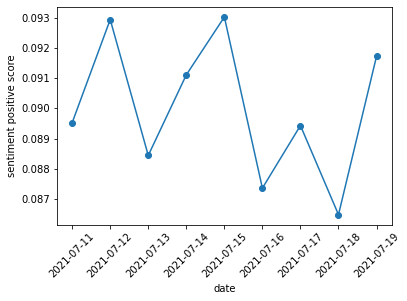

In [79]:
plt.plot(date_sentiment_1.index, date_sentiment_1.sentiment_pos ,marker='o')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('sentiment positive score') # after deleting ads tweets

### negative

Text(0, 0.5, 'sentiment negative score')

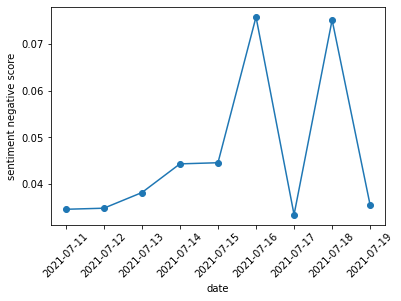

In [80]:
plt.plot(date_sentiment_1.index, date_sentiment_1.sentiment_neg ,marker='o')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('sentiment negative score')  # after deleting ads tweets

### Compound (focus on this one)

Text(0, 0.5, 'sentiment compound score')

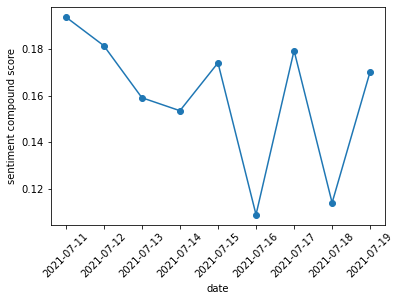

In [100]:
plt.plot(date_sentiment_1.index, date_sentiment_1.sentiment_compound ,marker='o')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('sentiment compound score') # - after deleting ads tweets' # same as 'before deleting ads tweets'

So you can do it two ways
1. Segment your tweets into positive and negative sentiment then take the average expression of all of the topics in both groups
2. Place your tweets into distinct groups based on the maximum expression label and then get the average sentiment in each group

## Sentiment & Stock price movement

In [83]:
#import pandas_datareader.data as web
#import datetime as dt


start = dt.datetime(2021, 7, 9)
end =  dt.datetime(2021, 7, 20) #dt.datetime.now() 

df_stock = web.DataReader('TSLA', 'yahoo', start, end)
df_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-07-09,658.909973,644.690002,653.179993,656.950012,18118500,656.950012
2021-07-12,687.239990,662.159973,662.200012,685.700012,25927000,685.700012
2021-07-13,693.280029,666.299988,686.320007,668.539978,20966100,668.539978
2021-07-14,678.609985,652.840027,670.750000,653.380005,21641200,653.380005
2021-07-15,666.140015,637.880005,658.390015,650.599976,20209600,650.599976
2021-07-16,656.700012,642.200012,654.679993,644.219971,16339800,644.219971
2021-07-19,647.200012,621.289978,629.890015,646.219971,21297100,646.219971
2021-07-20,662.390015,640.500000,651.989990,660.500000,15442700,660.500000


Text(0, 0.5, '$TSLA price')

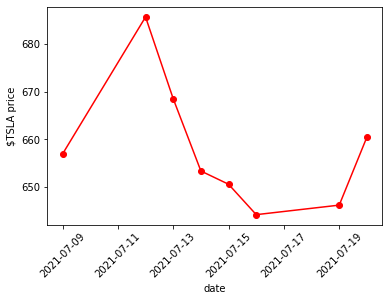

In [85]:
plt.plot(df_stock.index, df_stock.Close ,marker='o', color = 'red')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('$TSLA price')

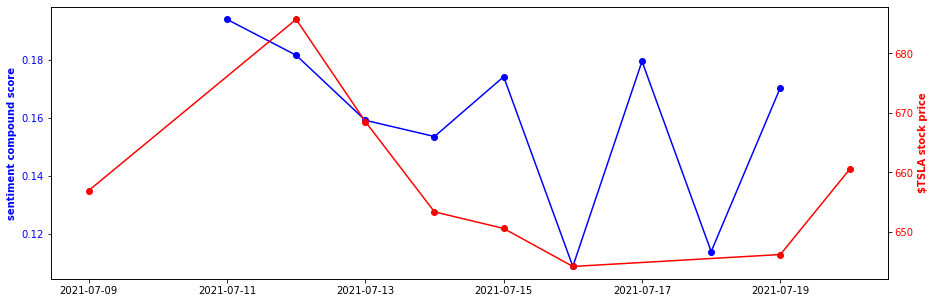

In [86]:
# plot together - legned - stock price and sentiment score ( $ TSLA and Tesla)  scatter

fig = plt.figure(figsize = [15,5])
#plt.xticks(rotation = 45)
#plt.xlabel('date', weight='bold')

ax1 = fig.add_subplot(111)
ax1.plot(date_sentiment_1.index, date_sentiment_1.sentiment_compound ,marker='o', color='blue')
ax1.set_ylabel('sentiment compound score' , color='blue', weight='bold')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')

ax2 = ax1.twinx()

ax2.plot(df_stock.index, df_stock.Close ,marker='o', color='r')
ax2.set_ylabel('$TSLA stock price', color='r' , weight='bold')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

# plt.savefig('charts/date_stock_sentiment-two-scales.png')
plt.show()


# Knn means clustering (Unsupervised Learning)
- on tweet-topic-matrix df

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


```Methods

fit_predict(X[, y, sample_weight])
Compute cluster centers and predict cluster index for each sample.

fit_transform(X[, y, sample_weight])
Compute clustering and transform X to cluster-distance space.
```

In [87]:
tweet_topic_matrix_df_1

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,0.032272,0.000000,0.000000,0.000000,0.004220,0.014347,0.011706,0.006102
1,0.000000,0.000000,0.000000,0.000000,0.037684,0.000000,0.000337,0.000000
2,0.002333,0.000000,0.000000,0.028774,0.027744,0.000000,0.000924,0.006925
3,0.005497,0.040468,0.000000,0.000000,0.023532,0.000558,0.000000,0.009687
4,0.031642,0.002862,0.000000,0.007618,0.019612,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
9431,0.019394,0.000000,0.000000,0.000000,0.000000,0.000000,0.116280,0.000000
9432,0.000000,0.000000,0.000000,0.000000,0.048548,0.000000,0.000000,0.000000
9433,0.000611,0.000000,0.000000,0.000000,0.010650,0.000154,0.003146,0.000000
9434,0.000000,0.000000,0.021051,0.000000,0.007071,0.001034,0.000000,0.017049


In [88]:
#tweet_topic_matrix_df_1  
tweet_topic_matrix_1   # total topic = 8 

array([[0.03227158, 0.        , 0.        , ..., 0.0143473 , 0.01170605,
        0.0061023 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00033729,
        0.        ],
       [0.00233311, 0.        , 0.        , ..., 0.        , 0.00092377,
        0.00692467],
       ...,
       [0.00061058, 0.        , 0.        , ..., 0.00015439, 0.00314597,
        0.        ],
       [0.        , 0.        , 0.02105097, ..., 0.00103426, 0.        ,
        0.01704859],
       [0.        , 0.        , 0.06509683, ..., 0.00355528, 0.        ,
        0.12003258]])

In [89]:
X =  tweet_topic_matrix_1   # = tweet_topic_matrix_df_1.values

##  use elbow method to find the best K

In [90]:
# from sklearn.cluster import KMeans

wcss = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state= 0)  # max_iter=1000, n_init = 100, random_state=1234) #
    kmeans.fit(X)   
    wcss.append(kmeans.inertia_)

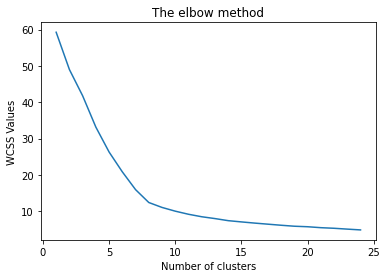

In [91]:
# plot to find the best n_cluster =  -> elbow

plt.plot(range(1,25), wcss)  
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS Values')
plt.show()                     # TA : what to do ? no elbow lol   # n = 8

## make KMeans model

In [92]:
# model 1
kmeansmodel = KMeans(n_clusters = 8 , init='k-means++', random_state=1234) # max_iter: default=300, #n_init: default=10
kmeansmodel.fit(X)
kmeansmodel.labels_

array([6, 6, 6, ..., 6, 6, 4], dtype=int32)

In [94]:
kmeans_clust = kmeansmodel.fit_predict(X)

In [95]:
# y_kmeans = kmeansmodel.fit_predict(X)
# kmeansmodel.cluster_centers_

## TruncatedSVD and plot

In [96]:
# X  = nmf_output  = tweet_topic_matrix_1 = nmf_1.fit_transform(tweet_word_matrix_1) 

Text(0.5, 1.0, 'Topic Clusters')

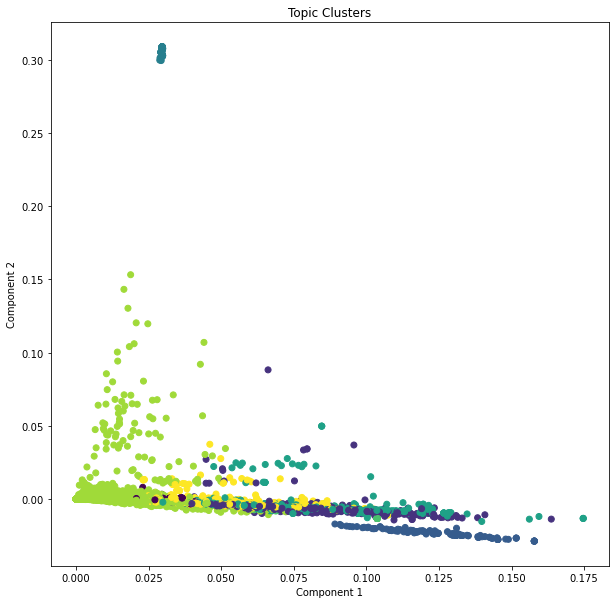

In [97]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics 
#k = 8
#kmeansmodel = KMeans(n_clusters = 8, init='k-means++', max_iter=1000, n_init = 100, random_state=1234) 
#kmeans_clust = kmeansmodel.fit_predict(X)

# Build SVD model  -> make plot
svd_model = TruncatedSVD(n_components=2)  # 2 components
nmf_1_svd = svd_model.fit_transform(X)


# plot axes using SVD decomposition
x_val = nmf_1_svd[:, 0]
y_val = nmf_1_svd[:, 1]

# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
# TA:  8 clustering not equals to 8 topics 
       # KMeans clustering is to find out 

# try TSNE

8 clusters(kmeans) is not equals to 8 topics (nmf)

Clustering is like doing a topic modeling on topics 

Each cluster can have different percentage of topics, for example: 
 - Cluster 1 has 10 % of topic 1 and 90 % of topic 2
 - Cluster 2 has 5 % of topic 1 and 70 % of topic 3 and 25% of topic 5

# TSNE for Clustering ploting
- use TSNE replace SVD
- since our problem has higher dimensions so TSNE can help
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [103]:
# X =  tweet_topic_matrix_1 # nmf.fit_transform

Text(0.5, 1.0, 'Topic Clusters')

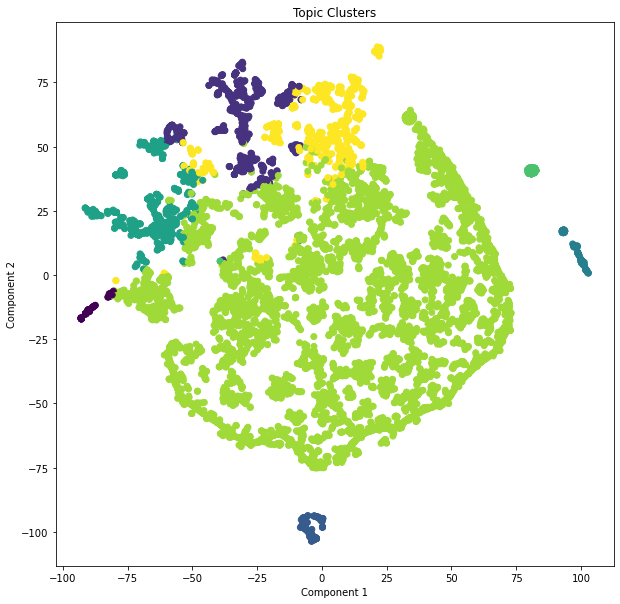

In [102]:
# nmf + kmeans + TSNE

#time_start = time.time()
tsne = TSNE(n_components=2) 
nmf_1_tsne = tsne.fit_transform(X)

#print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# plot axes using TSNE decomposition
x_val = nmf_1_tsne[:, 0]
y_val =nmf_1_tsne[:, 1]

# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")